In [2]:
import torch
from torch.functional import F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import copy
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sad_nns.uncertainty import *
from neurops import *

**NORTH:** Define a LeNet-style model. 

Use the `ModSequential` class to wrap the `ModConv2d` and `ModLinear` model, which allows us to mask, prune, and grow the model. 

Use the `track_activations` and `track_auxiliary_gradients` arguments to enable the tracking of activations and auxiliary gradients later. 

By adding the `input_shape` of the data, we can compute the conversion factor of how many input neurons to add to the first linear layer when a new output channel is added to the final convolutional layer. 

In [4]:
# set seed
torch.manual_seed(0)

In [8]:
model = ModSequential(
        ModConv2d(in_channels=1, out_channels=8, kernel_size=7, masked=True, padding=1, learnable_mask=True),
        ModConv2d(in_channels=8, out_channels=16, kernel_size=7, masked=True, padding=1, prebatchnorm=True, learnable_mask=True),
        ModConv2d(in_channels=16, out_channels=16, kernel_size=5, masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(64, 32, masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(32, 10, masked=True, prebatchnorm=True, nonlinearity=""),
        track_activations=True,
        track_auxiliary_gradients=True,
        input_shape = (1, 14, 14)
    ).to(device)
torch.compile(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Add EDL Loss Function
# KLDivergenceLoss, MaximumLikelihoodLoss, CrossEntropyBayesRisk, SquaredErrorBayesRisk
criterion = SquaredErrorBayesRisk()
kl_divergence = KLDivergenceLoss()

**NORTH:** Get a dataset and define standard training and testing functions.

In [30]:
dataset = datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                        ]))
train_set, val_set = torch.utils.data.random_split(dataset, lengths=[int(0.9*len(dataset)), int(0.1*len(dataset))])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                        ])),
    batch_size=128, shuffle=True)

def train(model, train_loader, optimizer, criterion, epochs=10, num_classes=10, val_loader=None, verbose=True):
    model.train()

    train_acc_vals = []
    train_u_vals = []
    test_acc_vals = []
    test_u_vals = []

    for epoch in range(epochs):
        correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)
            one_hot_target = F.one_hot(target, num_classes=num_classes)
            optimizer.zero_grad()
            output = model(data)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # calculate uncertainty
            evidence = F.relu(output)
            alpha = evidence + 1
            u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

            loss = criterion(evidence, one_hot_target)

            # calculate KL Divergence
            kl_div_loss = kl_divergence(evidence, one_hot_target)
            annealing_step = 10
            annealing_coef = torch.min(
                torch.tensor(1.0, dtype=torch.float32),
                torch.tensor(epoch / annealing_step, dtype=torch.float32),
            )
            
            loss = loss + annealing_coef * kl_div_loss

            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 and verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tUncertainty: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), u.mean()))
                
        train_acc, train_u = correct / len(train_loader.dataset), u.mean().detach().numpy().item()
        train_acc_vals.append(train_acc)
        train_u_vals.append(train_u)
        
        if val_loader is not None:
            print("Validation: ", end = "")
            test_acc, test_u = test(model, val_loader, criterion, plot=True)
            test_acc_vals.append(test_acc)
            test_u_vals.append(test_u)

    # Plotting the lines
    plt.plot(np.arange(epochs), train_acc_vals, label='Training Accuracy', color='blue')
    plt.plot(np.arange(epochs), train_u_vals, label='Training Uncertainty', color='purple')
    plt.plot(np.arange(epochs), test_acc_vals, label='Testing Accuracy', color='orange')
    plt.plot(np.arange(epochs), test_u_vals, label='Testing Uncertainty', color='red')
    plt.xticks(np.arange(0, epochs, 1))

    # Adding titles and labels
    plt.title('Accuracy vs. Uncertainty')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    # Show the plot
    plt.show()

def test(model, test_loader, criterion, num_classes=10, plot=False):
    model.eval()
    test_loss = 0
    correct = 0
    uncertainties = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            one_hot_target = F.one_hot(target, num_classes=num_classes)
            output = model(data)

            evidence = F.relu(output)
            alpha = evidence + 1
            u = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            uncertainties.append(u.mean())

            # test_loss += criterion(output, target).item() # sum up batch loss
            test_loss += criterion(output, one_hot_target).item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    avg_u = np.mean(uncertainties)
    
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Average Uncertainty: {:.4f}'.format(test_loss, correct, len(test_loader.dataset),
        accuracy, avg_u))
    
    if plot:
        return accuracy / 100, avg_u

**NORTH:** Pretrain the model before changing the architecture

Train Epoch: 0 [0/54000 (0%)]	Loss: 0.316645	Uncertainty: 0.447306
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.307465	Uncertainty: 0.446298
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.274082	Uncertainty: 0.445347
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.254492	Uncertainty: 0.436924
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.255923	Uncertainty: 0.441522
Validation: Average loss: 0.6267, Accuracy: 5860/6000 (97.67%), Average Uncertainty: 0.4373
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.305799	Uncertainty: 0.433896
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.228845	Uncertainty: 0.402163
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.236661	Uncertainty: 0.388784
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.218036	Uncertainty: 0.367280
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.212229	Uncertainty: 0.339632
Validation: Average loss: -0.1724, Accuracy: 5850/6000 (97.50%), Average Uncertainty: 0.3423


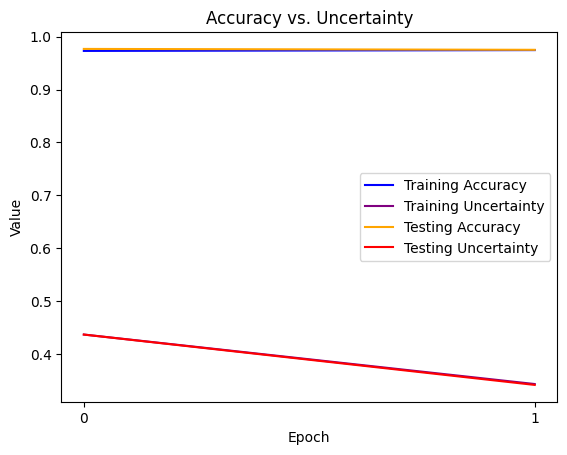

In [31]:
train(model, train_loader, optimizer, criterion, epochs=2, val_loader=val_loader)

### **NORTH:** Model Optimization Techniques

**NORTH:** Use a heuristic from `metrics.py` to measure the existing channels and neurons to determine which ones to prune.

The simplest one is measuring the norm of incoming weights to a neuron. We'll copy the model (so we have access to the original), then score each neuron and prune the lowest scoring ones within each layer. After running the following block, try uncommenting different lines to see how different metrics affect the model.

In [8]:
modded_model = copy.deepcopy(model)
modded_optimizer = torch.optim.SGD(modded_model.parameters(), lr=0.01)
modded_optimizer.load_state_dict(optimizer.state_dict())

for i in range(len(model)-1):
    scores = weight_sum(modded_model[i].weight)
    # scores = weight_sum(modded_model[i].weight) +  weight_sum(modded_model[i+1].weight, fanin=False, conversion_factor=model.conversion_factor if i == model.conversion_layer else -1)
    # scores = activation_variance(modded_model.activations[str(i)])
    # scores = svd_score(modded_model.activations[str(i)])
    # scores = nuclear_score(modded_model.activations[str(i)], average=i<3)
    # scores = modded_model[i+1].batchnorm.weight.abs() if i != modded_model.conversion_layer else modded_model[i+1].batchnorm.weight.abs().reshape(modded_model.conversion_factor,-1).sum(0) 
    # Before trying this line, run the following block: # scores = fisher_info(mask_grads[i])
    print("Layer {} scores: mean {:.3g}, std {:.3g}, min {:.3g}, smallest 25%:".format(i, scores.mean(), scores.std(), scores.min()), end=" ")
    to_prune = np.argsort(scores.detach().cpu().numpy())[:int(0.25*len(scores))]
    print(to_prune)
    modded_model.prune(i, to_prune, optimizer=modded_optimizer, clear_activations=True)
print("The pruned model has {} effective parameters.".format(modded_model.parameter_count(masked = True)))
print("Validation after pruning: ", end = "")
test(modded_model, val_loader, criterion)
train(modded_model, train_loader, modded_optimizer, criterion, epochs=2, val_loader=val_loader)

Layer 0 scores: mean 4.49, std 0.236, min 4.16, smallest 25%: [1 0]
Layer 1 scores: mean 8.73, std 0.447, min 8, smallest 25%: [7 5 1 3]
Layer 2 scores: mean 8.83, std 0.621, min 7.54, smallest 25%: [ 6 11  1 15]
Layer 3 scores: mean 3.26, std 0.33, min 2.49, smallest 25%: [19  7 11 21 29 15 28 23]
The pruned model has 9058 effective parameters.
Validation after pruning: Average loss: 0.0097, Accuracy: 4111/6000 (68.52%)
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.747649
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.685697
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.659413
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.621350
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.612561
Validation: Average loss: 0.0036, Accuracy: 5643/6000 (94.05%)
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.614553
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.399520
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.357692
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.307343
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.242675
Validation: Average lo

**NORTH:** Grow the model using a neurogenesis strategy similar to NORTH-Random.

In [9]:
modded_model_grow = copy.deepcopy(model)
modded_optimizer_grow = torch.optim.SGD(modded_model_grow.parameters(), lr=0.01)
modded_optimizer_grow.load_state_dict(optimizer.state_dict())

for iter in range(5):
    for i in range(len(modded_model_grow)-1):
        #score = orthogonality_gap(modded_model_grow.activations[str(i)])
        max_rank = modded_model_grow[i].width()
        score = effective_rank(modded_model_grow.activations[str(i)])
        to_add = max(score-int(0.95*max_rank), 0)
        print("Layer {} score: {}/{}, neurons to add: {}".format(i, score, max_rank, to_add))
        modded_model_grow.grow(i, to_add, fanin_weights="iterative_orthogonalization",
                               optimizer=modded_optimizer_grow)
    print("The grown model now has {} effective parameters.".format(modded_model_grow.parameter_count(masked = True)))
    print("Validation after growing: ", end = "")
    test(modded_model_grow, val_loader, criterion)
    train(modded_model_grow, train_loader, modded_optimizer_grow, criterion, epochs=2, val_loader=val_loader)

Layer 0 score: 8/8, neurons to add: 1
Layer 1 score: 16/16, neurons to add: 1
Layer 2 score: 16/16, neurons to add: 1
Layer 3 score: 32/32, neurons to add: 2
The grown model now has 16731 effective parameters.
Validation after growing: Average loss: 0.0108, Accuracy: 5708/6000 (95.13%)
Train Epoch: 0 [0/54000 (0%)]	Loss: 0.654126
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.593728
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.579987
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.567058
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.531281
Validation: Average loss: 0.0028, Accuracy: 5755/6000 (95.92%)
Train Epoch: 1 [0/54000 (0%)]	Loss: 0.585440
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.378533
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.316372
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.277143
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.250785
Validation: Average loss: 0.0171, Accuracy: 5732/6000 (95.53%)
Layer 0 score: 8/9, neurons to add: 0
Layer 1 score: 17/17, neurons to add: 1
Layer 2 score: 17/1